In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as plt
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets.utils import download_url


# Download e esplorazione dei dati

In [2]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


In [3]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
your_name = 'Renato'

In [5]:
def customize_dataset(dataframe_raw, rand_str):

    dataframe = dataframe_raw.copy(deep = True)         # Crea una copia del dataframe, ponendo deep = True le modifiche apportate non modifica il dataframe originale

    # Eliminazione di alcune righe
    dataframe = dataframe.sample(int(0.95 * len(dataframe)), random_state = int(ord(rand_str[0])))
    # .sample(): Restituisce un numero specificato di righe    /    random_state(): controlla il mescolamento dei dati prima di dividerli

    # Scalatura input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.

    # Scalatura target

    dataframe.charges = dataframe.charges * ord(rand_str[2])/100

    # Eliminazione colonne
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)

    return dataframe


In [6]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
457,57,female,30.79995,0,no,13024.852555
1050,44,female,37.32455,1,no,8825.448995
56,58,female,32.14325,2,no,14968.105625
311,19,female,24.94700,0,no,1911.113600
1288,20,male,39.79400,2,yes,42179.022600


**Domanda 1:** quante righe ha **'dataset'**?

In [7]:
num_rows = len(dataframe.index)
num_rows

1271

**Domanda 2:** quante righe ha 'dataset'?

In [8]:
num_columns = len(dataframe.columns)
num_columns

6

**Domanda 3:** Quali sono i titoli delle colonne di input?

In [9]:
input_cols = dataframe.columns[:5].tolist()
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Domanda 4:** Quali colonne non possiedono valori numerici?

In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_cols = dataframe.select_dtypes(exclude = numerics).columns.tolist()
categorical_cols

['sex', 'smoker']

**Domanda 5:** Quali sono i titoli delle colonne di output?

In [11]:
output_cols = dataframe.columns[5:6]
output_cols

Index(['charges'], dtype='object')

**Domanda bonus:** minimo, massimo e media dei valori in charges, si può vedere la distribuzione dei valori in un grafico?

In [12]:
max_charges = dataframe["charges"].max()
min_charges = dataframe["charges"].min()
mean_charges = dataframe["charges"].mean()

print('Il valore massimo è: ', max_charges)
print('Il valore minimo è: ', min_charges)
print('Il valore medio è: ', mean_charges)

Il valore massimo è:  70147.470811
Il valore minimo è:  1234.06129
Il valore medio è:  14433.083083868529


Distribuzione dei valori di charges:

<Axes: ylabel='Density'>

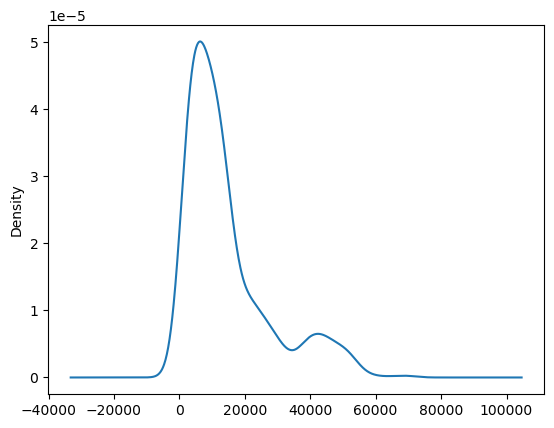

In [13]:
dataframe['charges'].plot(kind = 'kde')

# Preparazione dataset per il training

Per poter eserguire il training abbiamo bisogno di avere dei tensori, quindi faremo una trasformazione da pandas a pytorch: **Pandas --> NumPy --> Pytorch**

Passaggio da dataframe ad arry:

In [14]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep = True)        #copia dataframe

    # Conversione delle colonne non numeriche a numeriche
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes      # Categorizza attraverso codici numerici

    # Estrazione di input e output sotto forma di array numPy
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()

    return inputs_array, targets_array

In [15]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[57.     ,  0.     , 30.79995,  0.     ,  0.     ],
        [44.     ,  0.     , 37.32455,  1.     ,  0.     ],
        [58.     ,  0.     , 32.14325,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 35.148  ,  2.     ,  0.     ],
        [41.     ,  1.     , 29.088  ,  1.     ,  0.     ],
        [36.     ,  0.     , 30.3202 ,  0.     ,  0.     ]]),
 array([[13024.852555],
        [ 8825.448995],
        [14968.105625],
        ...,
        [40601.668833],
        [ 6910.4585  ],
        [ 5799.39338 ]]))

**Domanda 6:** convertire array numpy in tensori PyTorch (NB! Fare attenzione che siano float32)

In [16]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [17]:
inputs.dtype, targets.dtype     # Verifica tipologia dati

(torch.float32, torch.float32)

In [18]:
dataset = TensorDataset(inputs, targets)
print(len(dataset))

1271


**Domanda 7:** Scegliere un numero tra 0.1 e 0.2 per determinare la frazione di dati che verranno usati per creare un validation set, quindi usare random_split per creare training e validation set

In [19]:
val_percent = 0.2
val_size = int (num_rows * val_percent)
print('Dimensione validation test: ', val_size)
train_size = num_rows - val_size
print('Dimensione training test: ', train_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])

Dimensione validation test:  254
Dimensione training test:  1017


**Domanda 8:** Scegliere una dimensione di lotto per il data loader

In [20]:
batch_size = 8

In [21]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

In [22]:
for xb, yb in train_loader:
    print('inputs: ', xb)
    print('targets: ', yb)
    break

inputs:  tensor([[40.0000,  0.0000, 22.4422,  2.0000,  1.0000],
        [43.0000,  0.0000, 25.5227,  1.0000,  1.0000],
        [45.0000,  0.0000, 27.9214,  1.0000,  0.0000],
        [26.0000,  1.0000, 17.8467,  0.0000,  0.0000],
        [59.0000,  1.0000, 25.7146,  1.0000,  0.0000],
        [21.0000,  1.0000, 31.4110,  0.0000,  0.0000],
        [30.0000,  1.0000, 35.8853,  0.0000,  1.0000],
        [29.0000,  1.0000, 30.0324,  2.0000,  0.0000]])
targets:  tensor([[21388.6914],
        [23948.4766],
        [31174.2070],
        [ 2949.0442],
        [14205.3916],
        [ 1678.9432],
        [40645.2812],
        [19973.6641]])


# Creare un modello di regressione lineare

In [23]:
input_size = len(input_cols)
output_size = len(output_cols)

In [24]:
input_size

5

In [25]:
output_size

1

In [26]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)   

        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)  
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))  

In [27]:
model = InsuranceModel()

In [28]:
model.parameters()

<generator object Module.parameters at 0x7fd7905645f0>

In [29]:
model.linear.weight

Parameter containing:
tensor([[ 0.1712, -0.4165, -0.1237, -0.1863,  0.1933]], requires_grad=True)

In [30]:
model.linear.bias

Parameter containing:
tensor([-0.2033], requires_grad=True)

In [31]:
print(next(iter(val_loader)))

[tensor([[49.0000,  0.0000, 22.8361,  1.0000,  0.0000],
        [28.0000,  1.0000, 27.2498,  2.0000,  0.0000],
        [51.0000,  0.0000, 41.0666,  0.0000,  0.0000],
        [39.0000,  1.0000, 24.7551,  2.0000,  0.0000],
        [19.0000,  0.0000, 29.1890,  0.0000,  0.0000],
        [35.0000,  1.0000, 29.1890,  3.0000,  0.0000],
        [31.0000,  1.0000, 31.3757,  3.0000,  0.0000],
        [36.0000,  0.0000, 30.3202,  0.0000,  0.0000]]), tensor([[10523.6904],
        [ 4878.6035],
        [10863.2480],
        [ 7381.2109],
        [ 1917.5354],
        [ 6519.5308],
        [ 5967.5259],
        [ 5799.3936]])]


In [32]:
model.linear.weight

Parameter containing:
tensor([[ 0.1712, -0.4165, -0.1237, -0.1863,  0.1933]], requires_grad=True)

# Training del model

In [33]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Domanda 9:** usa la funzione evaluate per calcolare la perdita del validation set prima del training

In [34]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 13276.0400390625}


In [35]:
epochs = 5120
lr = 0.1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6466.1978
Epoch [40], val_loss: 6367.3857
Epoch [60], val_loss: 6341.3721
Epoch [80], val_loss: 6341.1133
Epoch [100], val_loss: 6295.9697
Epoch [120], val_loss: 6276.3862
Epoch [140], val_loss: 6264.3877
Epoch [160], val_loss: 6285.1675
Epoch [180], val_loss: 6237.2427
Epoch [200], val_loss: 6228.7402
Epoch [220], val_loss: 6253.1426
Epoch [240], val_loss: 6242.7490
Epoch [260], val_loss: 6232.6748
Epoch [280], val_loss: 6190.4375
Epoch [300], val_loss: 6190.2378
Epoch [320], val_loss: 6247.3779
Epoch [340], val_loss: 6151.9937
Epoch [360], val_loss: 6140.5908
Epoch [380], val_loss: 6209.0698
Epoch [400], val_loss: 6121.5430
Epoch [420], val_loss: 6185.5732
Epoch [440], val_loss: 6114.7417
Epoch [460], val_loss: 6197.1191
Epoch [480], val_loss: 6112.7295
Epoch [500], val_loss: 6112.8979
Epoch [520], val_loss: 6083.0166
Epoch [540], val_loss: 6057.6387
Epoch [560], val_loss: 6058.3677
Epoch [580], val_loss: 6041.8652
Epoch [600], val_loss: 6015.9541
Epoch [620], v

In [36]:
epochs = 5120
lr = 0.1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4086.4395
Epoch [40], val_loss: 4085.2065
Epoch [60], val_loss: 4063.3074
Epoch [80], val_loss: 4163.5933
Epoch [100], val_loss: 4125.0181
Epoch [120], val_loss: 4040.4165
Epoch [140], val_loss: 4172.0986
Epoch [160], val_loss: 4024.5198
Epoch [180], val_loss: 4069.4238
Epoch [200], val_loss: 4062.2090
Epoch [220], val_loss: 4055.7915
Epoch [240], val_loss: 4012.2139
Epoch [260], val_loss: 4002.0811
Epoch [280], val_loss: 3995.4575
Epoch [300], val_loss: 3997.7305
Epoch [320], val_loss: 4025.3843
Epoch [340], val_loss: 3982.7563
Epoch [360], val_loss: 4079.0999
Epoch [380], val_loss: 3972.9517
Epoch [400], val_loss: 3968.5725
Epoch [420], val_loss: 4070.0334
Epoch [440], val_loss: 3964.0298
Epoch [460], val_loss: 3989.2783
Epoch [480], val_loss: 3975.8706
Epoch [500], val_loss: 3966.5020
Epoch [520], val_loss: 3956.9287
Epoch [540], val_loss: 3945.9292
Epoch [560], val_loss: 3969.9724
Epoch [580], val_loss: 3998.2285
Epoch [600], val_loss: 4034.9048
Epoch [620], v

In [37]:
epochs = 5120
lr = 0.1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3858.8059
Epoch [40], val_loss: 3826.6509
Epoch [60], val_loss: 3835.7273
Epoch [80], val_loss: 3853.5774
Epoch [100], val_loss: 3797.8125
Epoch [120], val_loss: 3819.4927
Epoch [140], val_loss: 3813.9976
Epoch [160], val_loss: 3844.7734
Epoch [180], val_loss: 3810.1311
Epoch [200], val_loss: 3823.6023
Epoch [220], val_loss: 3865.7068
Epoch [240], val_loss: 3807.7388
Epoch [260], val_loss: 3812.0000
Epoch [280], val_loss: 3874.4880
Epoch [300], val_loss: 3806.9336
Epoch [320], val_loss: 3808.3618
Epoch [340], val_loss: 3855.8096
Epoch [360], val_loss: 3808.5547
Epoch [380], val_loss: 3808.6965
Epoch [400], val_loss: 3805.0415
Epoch [420], val_loss: 3819.6077
Epoch [440], val_loss: 3797.3159
Epoch [460], val_loss: 3803.3674
Epoch [480], val_loss: 3845.2202
Epoch [500], val_loss: 3797.6353
Epoch [520], val_loss: 3830.9939
Epoch [540], val_loss: 3826.2803
Epoch [560], val_loss: 3984.8394
Epoch [580], val_loss: 3829.3159
Epoch [600], val_loss: 3798.9238
Epoch [620], v

In [ ]:
epochs = 5120
lr = 0.1
history4 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
epochs = 5120
lr = 0.1
history5 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
val_loss = evaluate(model, val_loader)
val_loss

# NB! Valore di perdita altissimo, non riusciamo a ridurlo ulteriormente senza andare in overfitting

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = torch.max(model(inputs)).unsqueeze(0)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)